In [10]:
import pandas as pd
rway_img_df_ok = pd.read_csv("collection_images_download.csv")

In [11]:
rway_img_df = rway_img_df_ok.copy()

# EXTRACT BRAND FROM IMAGE NAME
# Creazione delle nuove colonne
rway_img_df['brand'] = rway_img_df['image_name'].str.lower()
rway_img_df['brand'] = rway_img_df['brand'].str.split('couture').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('ready-to-wear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.split('menswear').str[0]
rway_img_df['brand'] = rway_img_df['brand'].str.replace("-", " ")
rway_img_df['brand'] = rway_img_df['brand'].str.strip()

In [12]:
# create a small dataframe with the brand in scope
brand_in_scope = ['versace', 'hermes']
rway_img_df_small = pd.DataFrame()

for i,row in enumerate(rway_img_df['brand']):
    if row in brand_in_scope:
        rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
        
rway_img_df_small['image_path_no_bkgnd'] = rway_img_df_small['image_path'].astype(str)

# Execute 
# for each row in rway_img_df_small['image_path_no_bkgnd'] change the output path
for index, row in rway_img_df_small.iterrows():
    # Split the image path into base name and extension
    base_name, extension = row['image_path_no_bkgnd'].split('.')

    # Add "-no-bkgnd" to the base name
    new_base_name = f"{base_name}-no-bkgnd"

    # Concatenate the new base name with the extension
    new_image_path = f"{new_base_name}.{extension}"

    # Replace the original image path with the new image path
    rway_img_df_small.at[index, 'image_path_no_bkgnd'] = new_image_path


/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_926/2243863880.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_926/2243863880.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_926/2243863880.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rway_img_df_small = rway_img_df_small.append(rway_img_df.iloc[i])
/var/folders/3c/t3n4ptk97wl0rt09z81znxsw0000gn/T/ipykernel_926/2243863880.py:7: FutureWarning: The frame.append method is deprecated and will be removed from

In [13]:

#! it's takes 105m for 1694 imgs (% of full sample size)
#! Time estimate per img 2secs

"""from rembg import remove
import os

path_prefix = "./imgs/images/images/"

# Assuming rway_img_df_small is a pandas DataFrame containing the image paths
# with a column named 'image_path_no_bkgnd'

for index, row in rway_img_df_small.iterrows():
    input_path = f"{path_prefix}{row['image_path']}"
    output_path = f"{path_prefix}{row['image_path_no_bkgnd']}"

    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input_data = i.read()
            output_data = remove(input_data)
            o.write(output_data)"""


'from rembg import remove\nimport os\n\npath_prefix = "./imgs/images/images/"\n\n# Assuming rway_img_df_small is a pandas DataFrame containing the image paths\n# with a column named \'image_path_no_bkgnd\'\n\nfor index, row in rway_img_df_small.iterrows():\n    input_path = f"{path_prefix}{row[\'image_path\']}"\n    output_path = f"{path_prefix}{row[\'image_path_no_bkgnd\']}"\n\n    with open(input_path, \'rb\') as i:\n        with open(output_path, \'wb\') as o:\n            input_data = i.read()\n            output_data = remove(input_data)\n            o.write(output_data)'

In [14]:
# from small dataframe create train (90%) and test (10%) set
from sklearn.model_selection import train_test_split
train, test = train_test_split(rway_img_df_small, test_size=0.1, random_state=42)


In [8]:
"""import cv2
import numpy as np

output_image = cv2.imread(output_path)

# Resize the image to 260x260 pixels
resized_image = cv2.resize(output_image, (260, 260))

# Display the final resized image with a white background
cv2.imshow('Resized Image with White Background', resized_image)
cv2.waitKey(0)
cv2.destroyAllWindows()"""


"import cv2\nimport numpy as np\n\noutput_image = cv2.imread(output_path)\n\n# Resize the image to 260x260 pixels\nresized_image = cv2.resize(output_image, (260, 260))\n\n# Display the final resized image with a white background\ncv2.imshow('Resized Image with White Background', resized_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()"

# Image Classification with Attention

In [9]:
import os
import numpy as np
import pandas as pd
from tensorflow.python.keras.layers import Dense

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Multiply
from sklearn.model_selection import train_test_split


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply, Input
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf

# Load the image data and labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(rway_img_df_small['image_path_no_bkgnd'], rway_img_df_small['brand'], test_size=0.2, random_state=1234)

# Define image and label dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224

#Map the brand labels in y_train and y_val to their corresponding integer labels using the brand_to_label dictionary.
brand_to_label = {brand: i for i, brand in enumerate(np.unique(rway_img_df_small['brand']))}

# Map brand labels to integer labels
y_train = np.array([brand_to_label[brand] for brand in y_train])
y_val = np.array([brand_to_label[brand] for brand in y_val])

# Calculate the number of classes (num_classes) based on the unique labels.
num_classes = len(brand_to_label)

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

#Preprocess the images in X_train and X_val by applying the preprocess_image function to each image path.
X_train = np.array([preprocess_image(path) for path in X_train])
# Convert the integer labels in y_train and y_val to one-hot encoded vectors using tf.keras.utils.to_categorical.
X_val = np.array([preprocess_image(path) for path in X_val])

In [11]:
# Convert labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Add attention mechanism
attention = Dense(1, activation='tanh')(base_model.output)
attention = GlobalAveragePooling2D()(attention)
attention = Multiply()([base_model.output, attention])

# Add the top classification layer by applying a dense layer with a tanh activation function, followed by global average pooling and element-wise multiplication.
output = GlobalAveragePooling2D()(attention)
# Use global average pooling and a dense layer with softmax activation for multi-class classification.
output = Dense(num_classes, activation='softmax')(output)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save the trained model
model.save('./image_classification_model.h5') 


2023-07-17 20:05:51.162725: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-17 20:05:51.162764: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-17 20:05:51.162772: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-17 20:05:51.163098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-17 20:05:51.163292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-07-17 20:05:52.890498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 2.7139 - accuracy: 0.5262

2023-07-17 20:07:29.369261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 102s 2s/step - loss: 2.7139 - accuracy: 0.5262 - val_loss: 1.1355 - val_accuracy: 0.5192
Epoch 2/10
43/43 [==============================] - 104s 2s/step - loss: 0.7076 - accuracy: 0.5129 - val_loss: 0.6930 - val_accuracy: 0.5192
Epoch 3/10
43/43 [==============================] - 108s 3s/step - loss: 0.6942 - accuracy: 0.5077 - val_loss: 0.6926 - val_accuracy: 0.4808
Epoch 4/10
43/43 [==============================] - 109s 3s/step - loss: 0.7040 - accuracy: 0.5240 - val_loss: 0.6919 - val_accuracy: 0.5428
Epoch 5/10
43/43 [==============================] - 125s 3s/step - loss: 0.6958 - accuracy: 0.4827 - val_loss: 0.6933 - val_accuracy: 0.4808
Epoch 6/10
43/43 [==============================] - 132s 3s/step - loss: 0.6935 - accuracy: 0.4863 - val_loss: 0.6937 - val_accuracy: 0.4808
Epoch 7/10
43/43 [==============================] - 132s 3s/step - loss: 0.6933 - accuracy: 0.4886 - val_loss: 0.6929 - val_accuracy: 0.4838
Epoch 8/10
43/43 [======

/Users/elenaabcc/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from tensorflow.keras.models import load_model
model = load_model('./image_classification_model.h5')


2023-07-17 20:54:02.149182: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-17 20:54:02.149204: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-17 20:54:02.149209: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-17 20:54:02.149263: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-17 20:54:02.149397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:

# Define image and label dimensions (img_height and img_width) to resize the images during preprocessing.
img_height, img_width = 224, 224


1/1 [==============================] - 0s 64ms/step


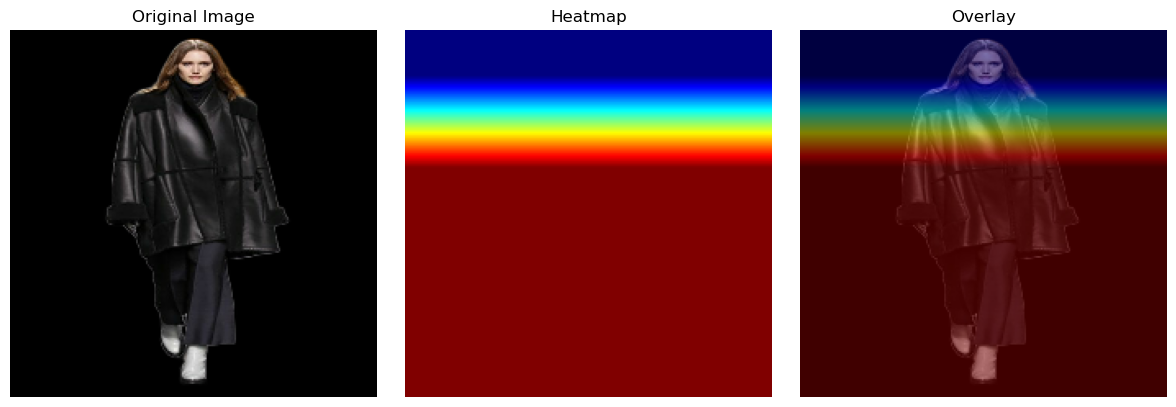

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the preprocess_image function to load, resize, and normalize the pixel values of the images.
def preprocess_image(image_path):
    image_path = './imgs/images/images/' + image_path  # Add the path prefix
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Choose an image for generating the heatmap
image_path = 'hermes-ready-to-wear-fall-winter-2016-paris-18627/Hermes-Ready-To-Wear-Fall-Winter-2016-Fashion-Show-Runway-Paris-Fashion-Week-0017-466x700-no-bkgnd.jpg'
image = preprocess_image(image_path)

# Reshape the image to match the model's input shape
image = np.expand_dims(image, axis=0)

# Get the feature maps from the model
conv_output = model.predict(image)

# Get the weights of the last dense layer (output layer) in the model
weights = model.layers[-1].get_weights()[0]

# Calculate the gradients of the predicted class with respect to the feature maps
grads = np.mean(conv_output, axis=(0, 1))

# Multiply the gradients with the pooled gradients to obtain the importance of each feature map channel
heatmap = np.mean(conv_output[0], axis=-1) * grads

# Normalize the heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to match the original image size
heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
overlay = cv2.addWeighted(np.uint8(255 * image[0]), 0.5, heatmap, 0.5, 0)

# Plot the original image, heatmap, and overlay
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].imshow(image[0])
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(heatmap)
ax[1].set_title('Heatmap')
ax[1].axis('off')
ax[2].imshow(overlay)
ax[2].set_title('Overlay')
ax[2].axis('off')
plt.tight_layout()
plt.show()
